# Determining the cost of cars

Service for the sale of used cars is developing an application to attract new customers. In it, customers can quickly find out the market value of their car. At our disposal are historical data: technical specifications, equipment and prices of cars. We need to build a model to determine the cost.

It is important for the client:

- quality of prediction;
- model prediction speed;
- model training speed.

## Preparing data for analysis

In [202]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 90)
#pd.set_option('display.max_rows', None)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import time

from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


In [203]:
pip install lightgbm

In [204]:
import lightgbm as light

In [205]:
try:
    df = pd.read_csv('C:/Users/annar/Yandex_Practicum/Sprint_14_Numerical_Methods/autos.csv') # Локальный путь
except:
    df_train = pd.read_csv('/datasets/autos.csv')  # Серверный путь

In [206]:
def data_info(data):
    return display(data.head()), display(data.info()), display(data.describe()), display(data.duplicated().sum()),display(data.isna().mean().apply('{:.1%}'.format))

In [207]:
data_info(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


4

DateCrawled           0.0%
Price                 0.0%
VehicleType          10.6%
RegistrationYear      0.0%
Gearbox               5.6%
Power                 0.0%
Model                 5.6%
Kilometer             0.0%
RegistrationMonth     0.0%
FuelType              9.3%
Brand                 0.0%
NotRepaired          20.1%
DateCreated           0.0%
NumberOfPictures      0.0%
PostalCode            0.0%
LastSeen              0.0%
dtype: object

(None, None, None, None, None)

There are missing values in the data that will need to be processed. Also at the stage of study, it is clear that the data has anomalous values in the columns `Price`, `Power`, `RegistrationMonth`. These columns have a minimum value of `0`, which is an anomaly. For the `Price` column, the value `0` essentially means that there is no target feature value, so before training the model, the rows with a zero value in the `Price` column will need to be deleted. The `RegistrationYear` column has a minimum value of `1000`, which is also an anomaly.

### Handling Missing Values

The columns `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` have missing values. These columns contain categorical data. It is not advisable to manually replace the missing values based on the study of other features of the object, since this may take too much time and most likely will have little effect on the quality of the model. Therefore, we will replace the missing values with a stub.

In [208]:
# Replacing missing values in all columns with a stub
df = df.fillna('Unknown')

In [209]:
# Checking that there are no missing values
df.isna().mean().apply('{:.1%}'.format)

DateCrawled          0.0%
Price                0.0%
VehicleType          0.0%
RegistrationYear     0.0%
Gearbox              0.0%
Power                0.0%
Model                0.0%
Kilometer            0.0%
RegistrationMonth    0.0%
FuelType             0.0%
Brand                0.0%
NotRepaired          0.0%
DateCreated          0.0%
NumberOfPictures     0.0%
PostalCode           0.0%
LastSeen             0.0%
dtype: object

### Exploring `DateCrawled`, `DateCreated`, `LastSeen` columns

Let's examine the columns `DateCrawled`, `DateCreated`, `LastSeen`

In [210]:
# Creating a YearCrawled column
df['YearCrawled'] = pd.to_datetime(df['DateCrawled'],format='%Y-%m-%d %H:%M:%S').dt.year
df['YearCrawled'].value_counts()

2016    354369
Name: YearCrawled, dtype: int64

In [211]:
# Creating a YearCreated column 
df['YearCreated'] = pd.to_datetime(df['DateCreated'],format='%Y-%m-%d %H:%M:%S').dt.year
df['YearCreated'].value_counts()

2016    354343
2015        25
2014         1
Name: YearCreated, dtype: int64

In [212]:
# Creating a YearLastSeen column
df['YearLastSeen'] = pd.to_datetime(df['LastSeen'],format='%Y-%m-%d %H:%M:%S').dt.year
df['YearLastSeen'].value_counts()

2016    354369
Name: YearLastSeen, dtype: int64

Almost all the values in the `DateCrawled`, `DateCreated`, `LastSeen` columns refer to 2016, so we will not use them when training the model

### Deleting rows with anomalous feature values

In [213]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen', 'YearCrawled', 'YearCreated', 'YearLastSeen'],
      dtype='object')

In [214]:
# Categorical Features
cat_names=[ 'VehicleType','Gearbox','Model', 'FuelType', 'Brand', 'NotRepaired']

In [215]:
# Numerical features
num_names = [ 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']

In [216]:
# Columns that will not be used when training the model
minor_names=['DateCrawled','DateCreated', 'LastSeen', 'YearCrawled', 'YearCreated', 'YearLastSeen']

In [217]:
def column_study(column):
    display(column.hist(bins=30, legend=True))

<AxesSubplot:>

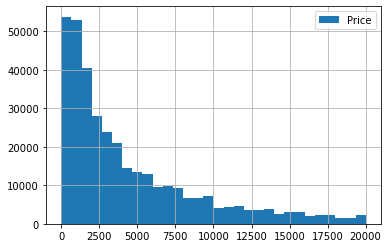

In [218]:
# Examining the 'Price' column
column_study(df['Price'])

In [219]:
df.query('Price<100').index

Int64Index([     7,     40,     59,     89,    111,    115,    152,    154,
               231,    268,
            ...
            354117, 354124, 354158, 354175, 354205, 354238, 354248, 354277,
            354309, 354364],
           dtype='int64', length=13314)

In [220]:
# Percentage of rows with an abnormal target value
len(df.query('Price<100'))/len(df)*100

3.757100649323163

In [221]:
# Removing columns with an abnormal target value
df = df.drop(df.query('Price<100').index, axis=0)
df.query('Price<100')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCrawled,YearCreated,YearLastSeen


<AxesSubplot:>

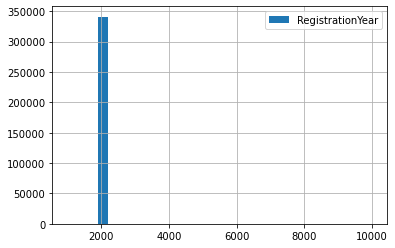

In [222]:
# Examining the 'RegistrationYear' column
column_study(df['RegistrationYear'])

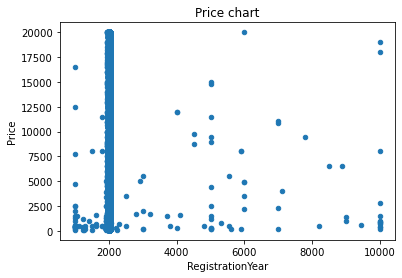

In [223]:
df.plot(x='RegistrationYear', y='Price', kind = 'scatter', title = 'Price chart')
plt.show()

In [224]:
df.query('(RegistrationYear<1900) | (RegistrationYear>2016)')['RegistrationYear'].count()

13730

In [225]:
# Percent of outliers in the RegistrationYear column
len(df.query('(RegistrationYear<1900) | (RegistrationYear>2016)'))/len(df)*100

4.025743648385157

In [226]:
# Removing outliers from the RegistrationYear column
df = df.drop(df.query('(RegistrationYear<1900) | (RegistrationYear>2016)').index, axis = 0)

In [227]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCrawled,YearCreated,YearLastSeen
0,2016-03-24 11:52:17,480,Unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,Unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016,2016,2016
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,Unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,2016,2016
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,2016,2016
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016,2016,2016
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2016,2016,2016
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07,2016,2016,2016
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39,2016,2016,2016
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,Unknown,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13,2016,2016,2016
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,Unknown,volkswagen,Unknown,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,2016,2016,2016
10,2016-03-26 19:54:18,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016-03-26 00:00:00,0,96224,2016-04-06 10:45:34,2016,2016,2016


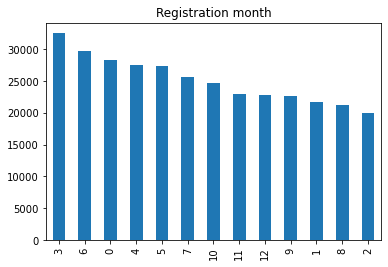

In [228]:
# Examining the 'RegistrationMonth' column
df['RegistrationMonth'].value_counts().plot(kind = 'bar', title = 'Registration month')
plt.show()

Let's look on the correlation of the data in `RegistrationMonth` and `RegistrationYear` with `Price` column.

In [229]:
# Price and RegistrationMonth correlation
df['RegistrationMonth'].corr(df['Price'])

0.08921795686497758

In [230]:
# Price and RegistrationYear correlation
df['RegistrationYear'].corr(df['Price'])

0.44067829296960265

We observe strong positive correlation between the `RegistrationYear` and `Price` columns. It can be assumed that the `RegistrationYear` feature will be very important for our model.

In [231]:
# Number of outliers in the RegistrationMonth column (RegistrationMonth=0)
df.query('RegistrationMonth==0')['RegistrationMonth'].count()

28244

In [232]:
# Percentage of outliers in the RegistrationMonth column
len(df.query('RegistrationMonth==0'))/len(df)*100

8.62873291071565

In [233]:
df.query('RegistrationMonth==0').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCrawled,YearCreated,YearLastSeen
0,2016-03-24 11:52:17,480,Unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,Unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016,2016,2016
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,Unknown,volkswagen,Unknown,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,2016,2016,2016
15,2016-03-11 21:39:15,450,small,1910,Unknown,0,ka,5000,0,petrol,ford,Unknown,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47,2016,2016,2016
16,2016-04-01 12:46:46,300,Unknown,2016,Unknown,60,polo,150000,0,petrol,volkswagen,Unknown,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46,2016,2016,2016
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,Unknown,opel,Unknown,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09,2016,2016,2016


For now, let's not remove the anomalous values ​​in the RegistrationMonth column. Maybe it's a data entry error.

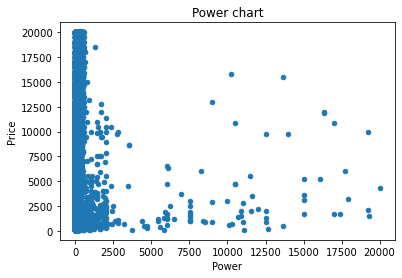

In [234]:
# Изучаем столбец 'Power'
df.plot(x='Power', y='Price', kind = 'scatter', title = 'Power chart')
plt.show()

In [235]:
# Minimum and maximum adequate vehicle power values
max_p = 550
min_p = 40

In [236]:
# Number of unique values of the 'Model' feature for which we have anomalous power values
len(df.query('(Power>=@max_p)|(Power<=@min_p)')['Model'].unique())

243

In [237]:
cars = df.query('(Power>=@max_p)|(Power<=@min_p)')['Model'].unique()
cars

array(['golf', 'ka', 'kangoo', 'signum', 'astra', 'polo', 'a4',
       'insignia', 'combo', 'corsa', '3er', '100', 'punto', 'Unknown',
       'other', 'v40', 'a3', '7er', 'e_klasse', 'c_klasse', 'sharan',
       'transporter', 'c1', 'fox', '6_reihe', 'c_max', '2_reihe', '5er',
       'touran', 'cooper', 'lupo', 'x_reihe', 'mondeo', 'a2', 'twingo',
       'fiesta', 'qashqai', 'fabia', 's_klasse', 'focus', 'civic', '1er',
       'megane', 'caddy', 'kalos', 'laguna', 'transit', 'omega',
       'cayenne', 'b_klasse', 'micra', 'corolla', 'clio', 'vito', 'clk',
       '500', 'meriva', 'a_klasse', 'ibiza', 'escort', 'cordoba',
       'passat', 'modus', 'a5', '3_reihe', 'v70', 'octavia', 'kaefer',
       'agila', 'a6', 'fortwo', 'antara', 'espace', 'touareg', 'primera',
       'picanto', 'bora', 'q7', 'berlingo', 'arosa', '1_reihe', 'leon',
       'jetta', 'almera', 'tigra', 'ptcruiser', 'scenic', 'samara',
       'galant', 'verso', 'swift', 'vectra', 'zafira', 'i_reihe',
       'mx_reihe', 's

In [238]:
# Number of rows with abnormal power values
df.query('(Power>=@max_p)|(Power<=@min_p)')['Power'].count()

33547

In [239]:
# Percent of rows with abnormal power values
len(df.query('(Power>=@max_p)|(Power<=@min_p)'))/len(df)*100

10.248835255480028

Let's replace the anomalous values with the average power value according to the table for a particular model (if this model is presented in a dataset with adequate power).

In [240]:
# Replacing anomalous power values with the average value over the model
# The average value is taken for rows with adequate power values for a particular model
for item in cars:
    median_val = 0
    median_val = df.query('Model==@item').query('(Power<@max_p)|(Power>@min_p)')['Power'].median()
    if median_val > min_p:
        df.loc[(df['Model']==item) & ((df['Power']>=max_p)|(df['Power']<=min_p)), 'Power'] = median_val
    print(item , median_val, df.query('Model==@item').query('(Power>=@max_p)|(Power<=@min_p)')['Power'].count())

golf 100.0 0
ka 60.0 0
kangoo 75.0 0
signum 155.0 0
astra 101.0 0
polo 60.0 0
a4 140.0 0
insignia 160.0 0
combo 75.0 0
corsa 60.0 0
3er 150.0 0
100 133.0 0
punto 60.0 0
Unknown 80.0 0
other 110.0 0
v40 116.0 0
a3 125.0 0
7er 235.0 0
e_klasse 170.0 0
c_klasse 143.0 0
sharan 116.0 0
transporter 102.0 0
c1 68.0 0
fox 54.0 0
6_reihe 121.0 0
c_max 116.0 0
2_reihe 88.0 0
5er 177.0 0
touran 136.0 0
cooper 120.0 0
lupo 50.0 0
x_reihe 190.0 0
mondeo 125.0 0
a2 75.0 0
twingo 58.0 0
fiesta 68.0 0
qashqai 131.0 0
fabia 75.0 0
s_klasse 231.0 0
focus 101.0 0
civic 90.0 0
1er 143.0 0
megane 107.0 0
caddy 102.0 0
kalos 83.0 0
laguna 120.0 0
transit 88.5 0
omega 136.0 0
cayenne 340.0 0
b_klasse 116.0 0
micra 60.0 0
corolla 97.0 0
clio 75.0 0
vito 116.0 0
clk 184.0 0
500 69.0 0
meriva 101.0 0
a_klasse 95.0 0
ibiza 75.0 0
escort 90.0 0
cordoba 75.0 0
passat 131.0 0
modus 75.0 0
a5 190.0 0
3_reihe 107.0 0
v70 163.0 0
octavia 116.0 0
kaefer 34.0 231
agila 60.0 0
a6 179.0 0
fortwo 61.0 0
antara 150.0 0
espa

In [241]:
# Percent of remaining columns with anomalous power
len(df.query('(Power>=@max_p)|(Power<=@min_p)')['Power'])/len(df)*100

0.17688841365615215

Let's remove the columns with anomalous power remaining after filling with the median value (0.18% of the data).

In [242]:
# Removing columns with abnormal power values
df=df.drop(df.query('(Power>=@max_p)|(Power<=@min_p)').index,axis=0)

In [243]:
df.reset_index(drop=True)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCrawled,YearCreated,YearLastSeen
0,2016-03-24 11:52:17,480,Unknown,1993,manual,100.00,golf,150000,0,petrol,volkswagen,Unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016,2016,2016
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.00,Unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,2016,2016
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.00,grand,125000,8,gasoline,jeep,Unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,2016,2016
3,2016-03-17 16:54:04,1500,small,2001,manual,75.00,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016,2016,2016
4,2016-03-31 17:25:20,3600,small,2008,manual,69.00,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2016,2016,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326741,2016-03-27 20:36:20,1150,bus,2000,manual,120.00,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23,2016,2016,2016
326742,2016-03-14 17:48:27,2200,Unknown,2005,Unknown,80.00,Unknown,20000,1,Unknown,sonstige_autos,Unknown,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52,2016,2016,2016
326743,2016-03-05 19:56:21,1199,convertible,2000,auto,101.00,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12,2016,2016,2016
326744,2016-03-19 18:57:12,9200,bus,1996,manual,102.00,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26,2016,2016,2016


In [244]:
# Check that we got rid of columns with anomalous power values
df.query('(Power>=@max_p)|(Power<=@min_p)')['Power'].count()

0

<AxesSubplot:>

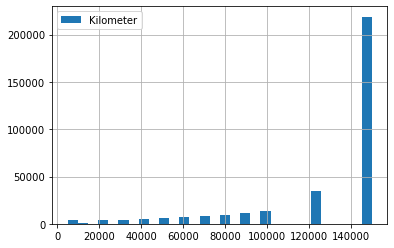

In [245]:
# Examine the `Kilometer` column
column_study(df['Kilometer'])

<AxesSubplot:>

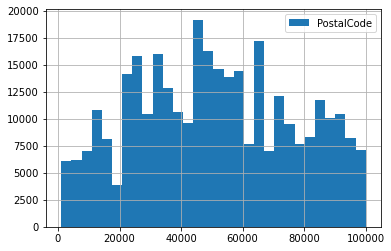

In [246]:
# Examine the `PostalCode` column
column_study(df['PostalCode'])

<AxesSubplot:>

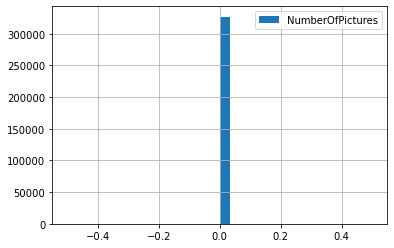

In [247]:
# Examine the `NumberOfPictures` column
column_study(df['NumberOfPictures'])

### Examining columns with categorical features

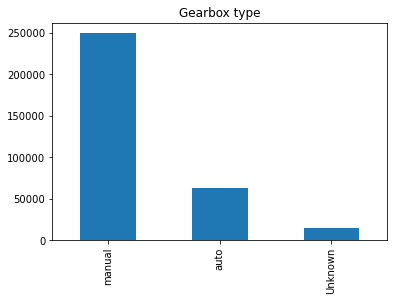

In [248]:
# Examining the `Gearbox` column
df['Gearbox'].value_counts().plot(kind = 'bar', title = 'Gearbox type')
plt.show()

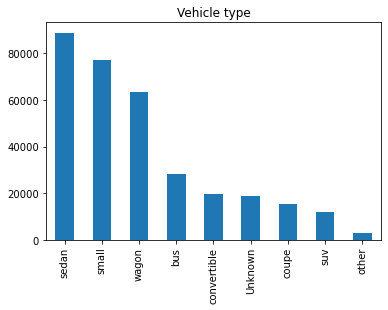

In [249]:
# Examining the `VehicleType` column
df['VehicleType'].value_counts().plot(kind = 'bar', title = 'Vehicle type')
plt.show()

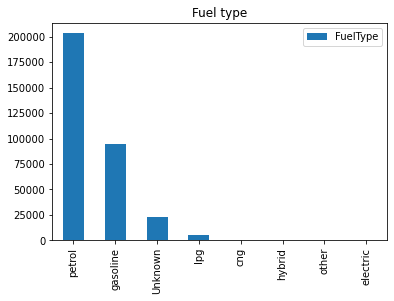

In [250]:
# Examining the `FuelType` column
df['FuelType'].value_counts().plot(kind = 'bar', legend=True, title = 'Fuel type' )
plt.show()

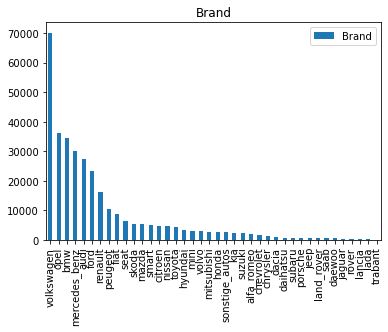

In [251]:
# Examining the `Brand` column
df['Brand'].value_counts().plot(kind = 'bar',legend=True, title = 'Brand')
plt.show()

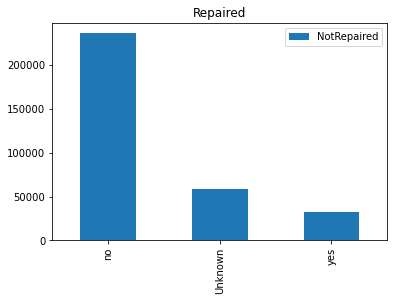

In [252]:
# Examining the `NotRepaired` column
df['NotRepaired'].value_counts().plot(kind = 'bar',legend=True, title = 'Repaired')
plt.show()

In [253]:
# Examining the `Model` column
df['Model'].value_counts()

golf                  26583
other                 22981
3er                   18571
Unknown               15169
polo                  11918
                      ...  
samara                    5
rangerover                3
serie_3                   3
range_rover_evoque        2
601                       2
Name: Model, Length: 250, dtype: int64

In [254]:
# We replace the 'Unknown' value with an 'other', because they have same meaning
df.loc[df['Model']=="Unknown",'Model']='other'
df['Model'].value_counts()

other                 38150
golf                  26583
3er                   18571
polo                  11918
corsa                 11443
                      ...  
samara                    5
rangerover                3
serie_3                   3
range_rover_evoque        2
601                       2
Name: Model, Length: 249, dtype: int64

### Removing duplicates

In [255]:
# Checking data for duplicates
df.duplicated().sum()

4

In [256]:
#Removing duplicates
df = df.drop_duplicates()

In [257]:
# Check if duplicates have been removed
df.duplicated().sum()

0

In [258]:
data_info(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCrawled,YearCreated,YearLastSeen
0,2016-03-24 11:52:17,480,Unknown,1993,manual,100.00,golf,150000,0,petrol,volkswagen,Unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016,2016,2016
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.00,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,2016,2016
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.00,grand,125000,8,gasoline,jeep,Unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,2016,2016
3,2016-03-17 16:54:04,1500,small,2001,manual,75.00,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016,2016,2016
4,2016-03-31 17:25:20,3600,small,2008,manual,69.00,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2016,2016,2016


<class 'pandas.core.frame.DataFrame'>
Int64Index: 326742 entries, 0 to 354368
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        326742 non-null  object 
 1   Price              326742 non-null  int64  
 2   VehicleType        326742 non-null  object 
 3   RegistrationYear   326742 non-null  int64  
 4   Gearbox            326742 non-null  object 
 5   Power              326742 non-null  float64
 6   Model              326742 non-null  object 
 7   Kilometer          326742 non-null  int64  
 8   RegistrationMonth  326742 non-null  int64  
 9   FuelType           326742 non-null  object 
 10  Brand              326742 non-null  object 
 11  NotRepaired        326742 non-null  object 
 12  DateCreated        326742 non-null  object 
 13  NumberOfPictures   326742 non-null  int64  
 14  PostalCode         326742 non-null  int64  
 15  LastSeen           326742 non-null  object 
 16  Ye

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,YearCrawled,YearCreated,YearLastSeen
count,"326,742.00","326,742.00","326,742.00","326,742.00","326,742.00","326,742.00","326,742.00","326,742.00","326,742.00","326,742.00"
mean,"4,643.72","2,002.66",119.20,"128,469.56",5.84,0.00,"50,813.77","2,016.00","2,016.00","2,016.00"
std,"4,547.06",6.80,52.31,"37,145.90",3.67,0.00,"25,742.14",0.00,0.01,0.00
min,100.00,"1,910.00",41.00,"5,000.00",0.00,0.00,"1,067.00","2,016.00","2,014.00","2,016.00"
25%,"1,200.00","1,999.00",77.00,"125,000.00",3.00,0.00,"30,519.00","2,016.00","2,016.00","2,016.00"
50%,"2,950.00","2,003.00",110.00,"150,000.00",6.00,0.00,"49,661.00","2,016.00","2,016.00","2,016.00"
75%,"6,700.00","2,007.00",145.00,"150,000.00",9.00,0.00,"71,364.00","2,016.00","2,016.00","2,016.00"
max,"20,000.00","2,016.00",544.00,"150,000.00",12.00,0.00,"99,998.00","2,016.00","2,016.00","2,016.00"


0

DateCrawled          0.0%
Price                0.0%
VehicleType          0.0%
RegistrationYear     0.0%
Gearbox              0.0%
Power                0.0%
Model                0.0%
Kilometer            0.0%
RegistrationMonth    0.0%
FuelType             0.0%
Brand                0.0%
NotRepaired          0.0%
DateCreated          0.0%
NumberOfPictures     0.0%
PostalCode           0.0%
LastSeen             0.0%
YearCrawled          0.0%
YearCreated          0.0%
YearLastSeen         0.0%
dtype: object

(None, None, None, None, None)

## Prepare data for model training

In [259]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCrawled,YearCreated,YearLastSeen
0,2016-03-24 11:52:17,480,Unknown,1993,manual,100.00,golf,150000,0,petrol,volkswagen,Unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016,2016,2016
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.00,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,2016,2016
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.00,grand,125000,8,gasoline,jeep,Unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,2016,2016
3,2016-03-17 16:54:04,1500,small,2001,manual,75.00,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016,2016,2016
4,2016-03-31 17:25:20,3600,small,2008,manual,69.00,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2016,2016,2016


In [260]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen', 'YearCrawled', 'YearCreated', 'YearLastSeen'],
      dtype='object')

### Splitting the dataset into features and  target

In [261]:
X=df[['RegistrationYear', 'Power', 'Kilometer',
                    'RegistrationMonth','PostalCode',
                    'VehicleType', 'Gearbox', 'Model',
                    'FuelType', 'Brand', 'NotRepaired']]

In [262]:
X.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,1993,100.00,150000,0,70435,Unknown,manual,golf,petrol,volkswagen,Unknown
1,2011,190.00,125000,5,66954,coupe,manual,other,gasoline,audi,yes
2,2004,163.00,125000,8,90480,suv,auto,grand,gasoline,jeep,Unknown
3,2001,75.00,150000,6,91074,small,manual,golf,petrol,volkswagen,no
4,2008,69.00,90000,7,60437,small,manual,fabia,gasoline,skoda,no


In [263]:
y = df['Price']

In [264]:
# Divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.15, random_state=12345)

In [265]:
# Checking the size of the train sample
display(X_train.shape, y_train.shape)

(277730, 11)

(277730,)

In [266]:
# Checking the size of the test sample
display( X_test.shape, y_test.shape)

(49012, 11)

(49012,)

In [267]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277730 entries, 292518 to 236019
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   RegistrationYear   277730 non-null  int64  
 1   Power              277730 non-null  float64
 2   Kilometer          277730 non-null  int64  
 3   RegistrationMonth  277730 non-null  int64  
 4   PostalCode         277730 non-null  int64  
 5   VehicleType        277730 non-null  object 
 6   Gearbox            277730 non-null  object 
 7   Model              277730 non-null  object 
 8   FuelType           277730 non-null  object 
 9   Brand              277730 non-null  object 
 10  NotRepaired        277730 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 25.4+ MB


### Scaling of numerical features and processing of categorical features

In [268]:
# determine categorical and numerical features
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

numerical_ix, categorical_ix

(Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
        'PostalCode'],
       dtype='object'),
 Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object'))

In [269]:
# define the data preparation for the columns
t = [('cat', OrdinalEncoder(), categorical_ix), ('num', StandardScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

## Model Training

### Random Forest

In [270]:
%%time
start = time.time()

# define the model
model = RandomForestRegressor(n_estimators = 60, max_depth = 8, random_state=12345)

# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])

# evaluate the pipeline using cross validation and calculate RMSE
scores_rf = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

end = time.time()
time_rf = end-start

Wall time: 7min 46s


In [271]:
# summarize the model performance
print(scores_rf)
print('RMSE: %.3f (%.3f)' % (scores_rf.mean(), scores_rf.std()))

[-2035.54878067 -2040.74909903 -2046.1422892  -2058.1107765
 -2031.73856594]
RMSE: -2042.458 (9.210)


### Linear Regression

In [272]:
%%time
start = time.time()

# define the model
model = LinearRegression()

# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])

# evaluate the pipeline using cross validation and calculate RMSE
scores_lr = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

end = time.time()
time_lr = end-start

Wall time: 13.6 s


In [273]:
# summarize the model performance
print('RMSE: %.3f (%.3f)' % (scores_lr.mean(), scores_lr.std()))

RMSE: -3113.771 (17.901)


### Gradient boosting model LightGBM

In [274]:
%%time

start = time.time()

# define the model
model = light.LGBMRegressor()

# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])

# evaluate the pipeline using cross validation and calculate RMSE
scores_light = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

end = time.time()
time_light = end-start

Wall time: 44.4 s


In [275]:
# summarize the model performance
print (scores_light)
print('RMSE: %.3f (%.3f)' % (scores_light.mean(), scores_light.std()))

[-1690.71755437 -1706.0788944  -1697.92982457 -1709.84494745
 -1702.719935  ]
RMSE: -1701.458 (6.650)


### Conclusions on the work of different models

In [276]:
# Displaying a table with the results of the model of each type on the train dataset
model_rmse_time={
    'Logistic regression':[scores_lr.mean(), time_lr],
    'Random Forest': [scores_rf.mean(), time_rf],
    'Gradient boosting LightGBM': [scores_light.mean(), time_light]
}

table=pd.DataFrame(data=model_rmse_time,
                   index=['Average RMSE on cross-validation', 'Model training time, sec']
                  )
display(table)

,Logistic regression,Random Forest,Gradient boosting LightGBM
Average RMSE on cross-validation,"-3,113.77","-2,042.46","-1,701.46"
"Model training time, sec",13.65,466.47,44.43


The best result in cross-validation was shown by the LightGBM gradient boosting model. In the next paragraph, we will check its operation on a test sample.

### Checking the best model on a test sample

In [277]:
%%time

start = time.time()

# define the model
model = light.LGBMRegressor()

# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])

pipeline.fit(X_train, y_train)

end = time.time()
time_teach = end-start

Wall time: 6.84 s


In [278]:
%%time

start = time.time()

prediction = pipeline.predict(X_test)
score_test = (mean_squared_error(y_test, prediction))**0.5

end = time.time()
time_predict = end-start

Wall time: 851 ms


In [279]:
print("Test score is {}".format(score_test))

Test score is 1704.9894030129333


Let's build a graph of the influence of features on the target feature for the LightGBM model.

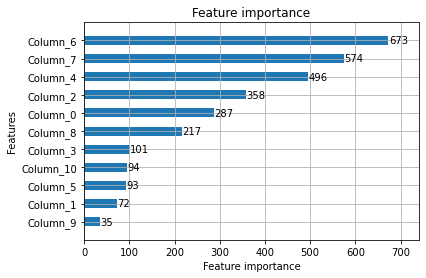

In [280]:
# plotting feature importance
light.plot_importance(model, height=.5)
plt.show()

In [281]:
col_transform

ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                 Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')),
                                ('num', StandardScaler(),
                                 Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'PostalCode'],
      dtype='object'))])

The `RegistrationYear`, `Power` and `Brand` features have the greatest influence on the target.

## Сonclusions

In [282]:
# Displaying a table with the results of the model of each type on the train dataset
model_rmse_time={
    'Logistic regression':[scores_lr.mean(), time_lr],
    'Random Forest': [scores_rf.mean(), time_rf],
    'Gradient boosting LightGBM': [scores_light.mean(), time_light]
}

table=pd.DataFrame(data=model_rmse_time,
                   index=['RMSE on cross-validation', 'Model training time, sec']
                  )
display(table)

,Logistic regression,Random Forest,Gradient boosting LightGBM
RMSE on cross-validation,"-3,113.77","-2,042.46","-1,701.46"
"Model training time, sec",13.65,466.47,44.43


In [283]:
# Displaying a table with the results of the best model
model_rmse_time={
    'Gradient boosting LightGBM': [score_test, time_teach, time_predict]
}

table=pd.DataFrame(data=model_rmse_time,
                   index=['RMSE on a test sample', 'Model training time, sec', 'Model prediction time, sec']
                  )
display(table)

,Gradient boosting LightGBM
RMSE on a test sample,"1,704.99"
"Model training time, sec",6.84
"Model prediction time, sec",0.85


The Gradient Boosting Model LightGBM showed the highest accuracy of work:

* RMSE metric for cross-validation RMSE = 1701
* RMSE metric on test set RMSE = 1705

Also in this problem, the calculation speed for the gradient boosting model turned out to be about 10 times higher compared to the random forest model.